# Deep learning modeling

Summary :
1. Multiple series prediction
2. Single serie prediction
   
   2.1 Predict 365 days in a row
   
   2.2 Predict one day at a time and re implementing before predicting next value

In [1]:
# --------------------------------------------------------------------------------------------------------
# Import necessary modules and libraries
# --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import itertools
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.initializers import HeNormal
import tensorflow as tf

## 1. Multiple series prediction

In [8]:
# --------------------------------------------------------------------------------------------------------
# Detect and handle outliers, interpolate missing values
# --------------------------------------------------------------------------------------------------------

# Keep a copy of original target before dropping stations
original_target = final_target.copy()

# Remove stations with later start dates
exclude_stations = [f'target_{station}' for station in excluded_stations.index]
final_target = final_target.drop(columns=exclude_stations)
anomalies_stations = [f'target_{station}' for station in anomaly_stations.index]
final_target = final_target.drop(columns=anomalies_stations)

def detect_small_outliers_rolling(series, window_size=10, threshold=0.85):
    """
    Detect outliers using a rolling median and deviation method.

    Parameters:
    series (pd.Series): Time series data.
    window_size (int): Size of the rolling window.
    threshold (float): The number of deviations away from the rolling median to consider as outliers.

    Returns:
    pd.Series: Boolean mask indicating outliers.
    """
    rolling_median = series.rolling(window=window_size, center=False).median()
    lower_bound = rolling_median - threshold * rolling_median
    outlier_mask = series < lower_bound

    return outlier_mask


def clean_outliers(final_target, window_size, threshold):
    outlier_mask = final_target.apply(detect_small_outliers_rolling, window_size=window_size, threshold=threshold)
    final_target[outlier_mask] = np.nan
    final_target = final_target.replace(0, np.nan)
    final_target.interpolate(method='pchip', inplace=True)
    final_target.fillna(0, inplace=True)
    #imputer = KNNImputer(n_neighbors=7, weights="distance")
    #final_target = pd.DataFrame(imputer.fit_transform(final_target), columns=final_target.columns, index=final_target.index)
    assert final_target.isna().sum().sum() == 0, "NaN values found after interpolation"

    return final_target

# --------------------------------------------------------------------------------------------------------
# Calculate MAPE excluding anomaly values
# --------------------------------------------------------------------------------------------------------

def calculate_mape_excluding_anomalies(actual, predicted, anomalies):
    valid_mask = ~anomalies  # Invert the mask to keep valid periods

    filtered_actual = actual[valid_mask]
    filtered_predicted = predicted[valid_mask]

    # Handle the case where no valid data is left
    if len(filtered_actual) == 0:
        return np.nan

    return mean_absolute_percentage_error(filtered_actual, filtered_predicted)

# --------------------------------------------------------------------------------------------------------
# Custom weights for covid lockdown
# --------------------------------------------------------------------------------------------------------

def custom_weights_covid(index, covid_weight=0.9):
    """
    Return lower weights for dates during the COVID-19 lockdown periods.
    """
    weights = np.ones(len(index))

    # First lockdown period
    lockdown1 = (index >= '2020-03-17') & (index <= '2020-05-11')
    # Second lockdown period
    lockdown2 = (index >= '2020-10-30') & (index <= '2020-12-15')
    # Third lockdown period
    lockdown3 = (index >= '2021-04-03') & (index <= '2021-05-03')

    weights[lockdown1 | lockdown2 | lockdown3] = covid_weight

    return weights

def weighted_mae(y_true, y_pred, weights):
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

In [9]:
# --------------------------------------------------------------------------------------------------------
# split a multivariate sequence into samples
# --------------------------------------------------------------------------------------------------------

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step


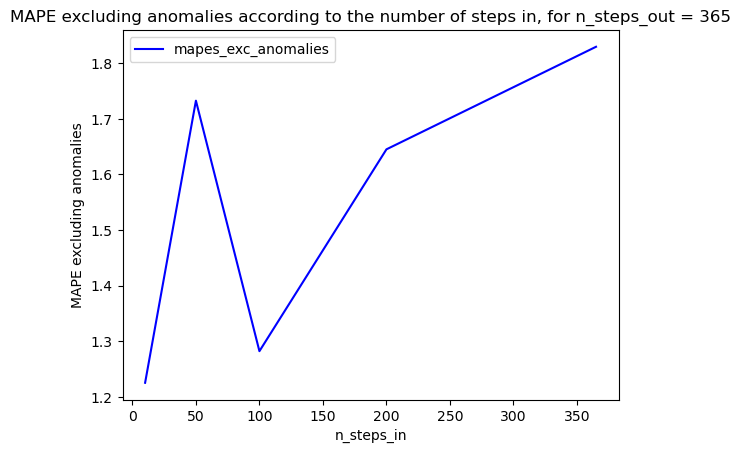

In [7]:
# --------------------------------------------------------------------------------------------------------
# Find the best value of n_steps_in for n_steps_out = 365, not optimized other hyperparameters
# --------------------------------------------------------------------------------------------------------

window_size, threshold = 21, 0.8

# Preprocess the data
cleaned_data = clean_outliers(final_target.copy(), window_size, threshold)

# Train-Test Split based on date
train_data = cleaned_data.loc[:'2021-12-31'].copy()
test_data = cleaned_data.loc['2015-12-31':].copy()

# Generate the anomaly flags for the cleaned data
anomaly_flags = detect_small_outliers_rolling(test_data, window_size, threshold)

# Initialize scalers
feature_scaler = StandardScaler()

# Fit the scaler on the X data
train_scaled = pd.DataFrame(feature_scaler.fit_transform(train_data), 
                              index=train_data.index, columns=train_data.columns)
test_scaled = pd.DataFrame(feature_scaler.transform(test_data), 
                             index=test_data.index, columns=test_data.columns)

# Convert each row to a NumPy array and store in a list
train_arrays = np.array([row.values for index, row in train_scaled.iterrows()])
test_arrays = np.array([row.values for index, row in test_scaled.iterrows()])

maes=[]
mapes=[]
mapes_exc_anomalies=[]


for i in [10, 50, 100, 200, 365]:

    # choose a number of time steps
    n_steps_in, n_steps_out = i, 365
    X_train, y_train = split_sequences(train_arrays, n_steps_in, n_steps_out)
    X_test, y_test = split_sequences(test_arrays, n_steps_in, n_steps_out)
    
    # Get number of features
    n_features = X_train.shape[2]

    # define model
    optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # clipvalue clips gradients to the range [-1, 1]

    model = Sequential()
    model.add(Input(shape=(n_steps_in, n_features)))
    model.add(LSTM(100, activation='tanh', kernel_initializer=HeNormal(), dropout = 0.4))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(100, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer=optimizer, loss='mae')
    
    # fit model
    model.fit(X_train, y_train, epochs=5, batch_size=1, validation_split=0.2, verbose = False)

    # Predict on the test set
    predictions = model.predict(X_test)
    
    #Get only the values of 2022 to evaluate the performances
    test_shape = y_test.shape
    test_reshaped = y_test.reshape(-1, test_shape[-1]) # Step 1: Reshape the 3D array to 2D
    test_inverse_transformed = feature_scaler.inverse_transform(test_reshaped) # Step 2: Apply inverse_transform
    y_true = test_inverse_transformed.reshape(test_shape) # Step 3: Reshape back to the original 3D shape
    y_true = np.round(y_true, 0)
    
    pred_shape = predictions.shape
    pred_reshaped = predictions.reshape(-1, pred_shape[-1]) # Step 1: Reshape the 3D array to 2D
    pred_inverse_transformed = feature_scaler.inverse_transform(pred_reshaped) # Step 2: Apply inverse_transform
    pred = pred_inverse_transformed.reshape(pred_shape) # Step 3: Reshape back to the original 3D shape
    pred = np.round(pred, 0)
    
    # Print the performances
    mae = mean_absolute_error(y_true[-1], pred[-1])
    maes.append(mae)
    
    mape = mean_absolute_percentage_error(y_true[-1], pred[-1])
    mapes.append(mape)
    
    mape_exc_anomalies = calculate_mape_excluding_anomalies(y_true[-1], pred[-1], anomaly_flags['2022-01-01':])
    mapes_exc_anomalies.append(mape_exc_anomalies)
    
#plt.plot(maes, c = 'r', label = 'maes')
#plt.plot(mapes, c = 'g', label = 'mapes')x
plt.plot([10, 50, 100, 200, 365], mapes_exc_anomalies, c = 'b', label = 'mapes_exc_anomalies')
plt.title('MAPE excluding anomalies according to the number of steps in, for n_steps_out = 365')
plt.xlabel('n_steps_in')
plt.ylabel('MAPE excluding anomalies')
plt.legend();

In [7]:
# --------------------------------------------------------------------------------------------------------
# Manual GridSearch to find best hyperparameters: nb neurons, nb epochs, batch size, loss function
# --------------------------------------------------------------------------------------------------------

window_size, threshold = 21, 0.8

# Preprocess the data
cleaned_data = clean_outliers(final_target.copy(), window_size, threshold)

# Train-Test Split based on date
train_data = cleaned_data.loc[:'2021-12-31'].copy()
test_data = cleaned_data.loc['2015-12-31':].copy()

# Generate the anomaly flags for the cleaned data
anomaly_flags = detect_small_outliers_rolling(test_data, window_size, threshold)

# Initialize scalers
feature_scaler = StandardScaler()

# Fit the scaler on the X data
train_scaled = pd.DataFrame(feature_scaler.fit_transform(train_data), 
                              index=train_data.index, columns=train_data.columns)
test_scaled = pd.DataFrame(feature_scaler.transform(test_data), 
                             index=test_data.index, columns=test_data.columns)

# Convert each row to a NumPy array and store in a list
train_arrays = np.array([row.values for index, row in train_scaled.iterrows()])
test_arrays = np.array([row.values for index, row in test_scaled.iterrows()])

# choose a number of time steps
n_steps_in, n_steps_out = 50, 365
X_train, y_train = split_sequences(train_arrays, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test_arrays, n_steps_in, n_steps_out)
    
# Get number of features
n_features = X_train.shape[2]


maes=[]
mapes=[]
mapes_exc_anomalies=[]
hyperparameters = []
#predictions = {}

# Define parameters combination
param_grid = {
    'n_nodes': [100, 200],
    'n_epochs': [5, 10],
    'n_batch': [1, 10, 25],
    'n_loss': ['mae', 'mape']
}
param_combinations = list(itertools.product(param_grid['n_nodes'], param_grid['n_epochs'], param_grid['n_batch'], param_grid['n_loss']))

for params in param_combinations:
    
    print(params)
    n_nodes, n_epochs, n_batch, n_loss = params
    
    # define model
    optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # clipvalue clips gradients to the range [-1, 1]
    
    model = Sequential()
    model.add(Input(shape=(n_steps_in, n_features)))
    model.add(LSTM(n_nodes, activation='tanh', kernel_initializer=HeNormal(), dropout = 0.4))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(n_nodes, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer=optimizer, loss=n_loss)
    
    # fit model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose = False)
    
    # Predict on the test set
    predictions = model.predict(X_test, verbose = False)

    #Get only the values of 2022 to evaluate the performances
    test_shape = y_test.shape
    test_reshaped = y_test.reshape(-1, test_shape[-1]) # Step 1: Reshape the 3D array to 2D
    test_inverse_transformed = feature_scaler.inverse_transform(test_reshaped) # Step 2: Apply inverse_transform
    y_true = test_inverse_transformed.reshape(test_shape) # Step 3: Reshape back to the original 3D shape
    y_true = np.round(y_true, 0)
    
    pred_shape = predictions.shape
    pred_reshaped = predictions.reshape(-1, pred_shape[-1]) # Step 1: Reshape the 3D array to 2D
    pred_inverse_transformed = feature_scaler.inverse_transform(pred_reshaped) # Step 2: Apply inverse_transform
    pred = pred_inverse_transformed.reshape(pred_shape) # Step 3: Reshape back to the original 3D shape
    pred = np.round(pred, 0)
    
    # Store performances and results
    #predictions[params] = pred
    hyperparameters.append(params)
    
    mae = mean_absolute_error(y_true[-1], pred[-1])
    maes.append(mae)
    
    mape = mean_absolute_percentage_error(y_true[-1], pred[-1])
    mapes.append(mape)
    
    mape_exc_anomalies = calculate_mape_excluding_anomalies(y_true[-1], pred[-1], anomaly_flags['2022-01-01':])
    mapes_exc_anomalies.append(mape_exc_anomalies)

(100, 5, 1, 'mae')
(100, 5, 1, 'mape')
(100, 5, 10, 'mae')
(100, 5, 10, 'mape')
(100, 5, 25, 'mae')
(100, 5, 25, 'mape')
(100, 10, 1, 'mae')
(100, 10, 1, 'mape')
(100, 10, 10, 'mae')
(100, 10, 10, 'mape')
(100, 10, 25, 'mae')
(100, 10, 25, 'mape')
(200, 5, 1, 'mae')
(200, 5, 1, 'mape')
(200, 5, 10, 'mae')
(200, 5, 10, 'mape')
(200, 5, 25, 'mae')
(200, 5, 25, 'mape')
(200, 10, 1, 'mae')
(200, 10, 1, 'mape')
(200, 10, 10, 'mae')
(200, 10, 10, 'mape')
(200, 10, 25, 'mae')
(200, 10, 25, 'mape')


In [47]:
# Get best results and hyperparameters
results = pd.DataFrame(hyperparameters)
results = results.rename(columns = {0: 'Nb nodes', 1:'Nb epochs', 2:'Nb batch', 3:'Loss'})
results['MAE'] = maes
results['MAPES'] = mapes
results['MAPES exc anomalies'] = mapes_exc_anomalies
results[results['MAPES exc anomalies'] == results['MAPES exc anomalies'].min()]

,Nb nodes,Nb epochs,Nb batch,Loss,MAE,MAPES,MAPES exc anomalies
0,100,5,1,mae,9737.659587,2.036912,1.404715


## 2. Single serie prediction

### 2.1 Predict 365 days in a row

In [ ]:
# --------------------------------------------------------------------------------------------------------
# Detect and handle outliers, interpolate missing values
# --------------------------------------------------------------------------------------------------------

# Keep a copy of original target before dropping stations
original_target = final_target.copy()

# Remove stations with later start dates
exclude_stations = [f'target_{station}' for station in excluded_stations.index]
final_target = final_target.drop(columns=exclude_stations)
anomalies_stations = [f'target_{station}' for station in anomaly_stations.index]
final_target = final_target.drop(columns=anomalies_stations)

def detect_small_outliers_rolling(series, window_size=10, threshold=0.85):
    """
    Detect outliers using a rolling median and deviation method.

    Parameters:
    series (pd.Series): Time series data.
    window_size (int): Size of the rolling window.
    threshold (float): The number of deviations away from the rolling median to consider as outliers.

    Returns:
    pd.Series: Boolean mask indicating outliers.
    """
    rolling_median = series.rolling(window=window_size, center=False).median()
    lower_bound = rolling_median - threshold * rolling_median
    outlier_mask = series < lower_bound

    return outlier_mask


def clean_outliers(final_target, window_size, threshold):
    outlier_mask = final_target.apply(detect_small_outliers_rolling, window_size=window_size, threshold=threshold)
    final_target[outlier_mask] = np.nan
    final_target = final_target.replace(0, np.nan)
    final_target.interpolate(method='pchip', inplace=True)
    final_target.fillna(0, inplace=True)
    #imputer = KNNImputer(n_neighbors=7, weights="distance")
    #final_target = pd.DataFrame(imputer.fit_transform(final_target), columns=final_target.columns, index=final_target.index)
    assert final_target.isna().sum().sum() == 0, "NaN values found after interpolation"

    return final_target

# --------------------------------------------------------------------------------------------------------
# Calculate MAPE excluding anomaly values
# --------------------------------------------------------------------------------------------------------

def calculate_mape_excluding_anomalies(actual, predicted, anomalies):
    valid_mask = ~anomalies  # Invert the mask to keep valid periods

    filtered_actual = actual[valid_mask]
    filtered_predicted = predicted[valid_mask]

    # Handle the case where no valid data is left
    if len(filtered_actual) == 0:
        return np.nan

    return mean_absolute_percentage_error(filtered_actual, filtered_predicted)

# --------------------------------------------------------------------------------------------------------
# Custom weights for covid lockdown
# --------------------------------------------------------------------------------------------------------

def custom_weights_covid(index, covid_weight=0.9):
    """
    Return lower weights for dates during the COVID-19 lockdown periods.
    """
    weights = np.ones(len(index))

    # First lockdown period
    lockdown1 = (index >= '2020-03-17') & (index <= '2020-05-11')
    # Second lockdown period
    lockdown2 = (index >= '2020-10-30') & (index <= '2020-12-15')
    # Third lockdown period
    lockdown3 = (index >= '2021-04-03') & (index <= '2021-05-03')

    weights[lockdown1 | lockdown2 | lockdown3] = covid_weight

    return weights

def weighted_mae(y_true, y_pred, weights):
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

In [ ]:
# --------------------------------------------------------------------------------------------------------
# split a univariate sequence into samples
# --------------------------------------------------------------------------------------------------------

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

Epoch 1/4
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7074 - val_loss: 0.7277
Epoch 2/4
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6284 - val_loss: 0.6110
Epoch 3/4
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6448 - val_loss: 0.5952
Epoch 4/4
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5887 - val_loss: 0.5438


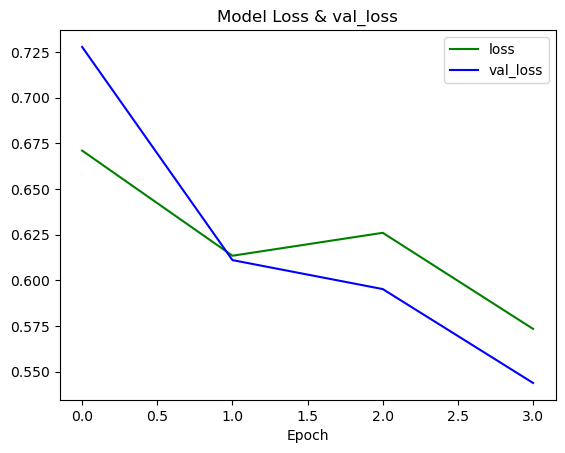

In [177]:
# --------------------------------------------------------------------------------------------------------
# Make prediction of 1 station (target_OWM) with n_steps_in = 10, n_steps_out = 365
# --------------------------------------------------------------------------------------------------------

window_size, threshold = 21, 0.8

# Preprocess the data
cleaned_data = clean_outliers(final_target.copy(), window_size, threshold)

# Remove the 9 stations to perfrom individually
cleaned_data = cleaned_data[cleaned_data.index >= '2017-01-17']['target_OWM']

# Train-Test Split based on date
train_data = pd.DataFrame(cleaned_data.loc[:'2021-12-31'].copy())
test_data = pd.DataFrame(cleaned_data.loc['2015-12-31':].copy())

# Generate the anomaly flags for the cleaned data
anomaly_flags = detect_small_outliers_rolling(test_data, window_size, threshold)

# Initialize scalers
feature_scaler = StandardScaler()

# Fit the scaler on the X data
train_scaled = pd.DataFrame(feature_scaler.fit_transform(train_data), 
                              index=train_data.index, columns=train_data.columns)
test_scaled = pd.DataFrame(feature_scaler.transform(test_data), 
                             index=test_data.index, columns=test_data.columns)

# Convert each row to a NumPy array and store in a list
train_arrays = np.array([row.values for index, row in train_scaled.iterrows()])
test_arrays = np.array([row.values for index, row in test_scaled.iterrows()])

# choose a number of time steps
n_steps_in, n_steps_out = 10, 365
X_train, y_train = split_sequence(train_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_scaled, n_steps_in, n_steps_out)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

# define model
optimizer = Adam(learning_rate=0.01, clipvalue=1.0)  # clipvalue clips gradients to the range [-1, 1]

model = Sequential()
model.add(Input(shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='tanh', kernel_initializer=HeNormal(), dropout = 0.4))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer=optimizer, loss='mae')

# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=1, validation_split=0.2)

plt.plot(history.history['loss'], c = 'g', label = 'loss')
plt.plot(history.history['val_loss'], c = 'b', label = 'val_loss')
plt.title('Model Loss & val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [277]:
# Predict on the test set
predictions = model.predict(X_test)

#Get only the values of 2022 to evaluate the performances
test_shape = y_test.shape
test_reshaped = y_test.reshape(-1, test_shape[-1]) # Step 1: Reshape the 3D array to 2D
test_inverse_transformed = feature_scaler.inverse_transform(test_reshaped) # Step 2: Apply inverse_transform
y_true = test_inverse_transformed.reshape(test_shape) # Step 3: Reshape back to the original 3D shape
y_true = np.round(y_true, 0)

pred_shape = predictions.shape
pred_reshaped = predictions.reshape(-1, pred_shape[-1]) # Step 1: Reshape the 3D array to 2D
pred_inverse_transformed = feature_scaler.inverse_transform(pred_reshaped) # Step 2: Apply inverse_transform
pred = pred_inverse_transformed.reshape(pred_shape) # Step 3: Reshape back to the original 3D shape
pred = np.round(pred, 0)

# Print the performances
mae = np.abs(pred[-1] - y_true[-1]).mean()
print("Mean Absolute Error:", mae)

mape = mean_absolute_percentage_error(y_true[-1], pred[-1])
print("MAPE:", mape)

mape_exc_anomalies = calculate_mape_excluding_anomalies(y_true[-1], pred[-1], anomaly_flags['2022-01-01':])
print('MAPE excluding anomalies:', mape_exc_anomalies)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Mean Absolute Error: 36.00821917808219
MAPE: 0.49736296327201385
MAPE excluding anomalies: 0.49736296327201385


### 2.2 Predict one day at a time and re implementing before predicting next value 

In [ ]:
# --------------------------------------------------------------------------------------------------------
# Detect and handle outliers, interpolate missing values
# --------------------------------------------------------------------------------------------------------

# Keep a copy of original target before dropping stations
original_target = final_target.copy()

# Remove stations with later start dates
exclude_stations = [f'target_{station}' for station in excluded_stations.index]
final_target = final_target.drop(columns=exclude_stations)
anomalies_stations = [f'target_{station}' for station in anomaly_stations.index]
final_target = final_target.drop(columns=anomalies_stations)

def detect_small_outliers_rolling(series, window_size=10, threshold=0.85):
    """
    Detect outliers using a rolling median and deviation method.

    Parameters:
    series (pd.Series): Time series data.
    window_size (int): Size of the rolling window.
    threshold (float): The number of deviations away from the rolling median to consider as outliers.

    Returns:
    pd.Series: Boolean mask indicating outliers.
    """
    rolling_median = series.rolling(window=window_size, center=False).median()
    lower_bound = rolling_median - threshold * rolling_median
    outlier_mask = series < lower_bound

    return outlier_mask


def clean_outliers(final_target, window_size, threshold):
    outlier_mask = final_target.apply(detect_small_outliers_rolling, window_size=window_size, threshold=threshold)
    final_target[outlier_mask] = np.nan
    final_target = final_target.replace(0, np.nan)
    final_target.interpolate(method='pchip', inplace=True)
    final_target.fillna(0, inplace=True)
    #imputer = KNNImputer(n_neighbors=7, weights="distance")
    #final_target = pd.DataFrame(imputer.fit_transform(final_target), columns=final_target.columns, index=final_target.index)
    assert final_target.isna().sum().sum() == 0, "NaN values found after interpolation"

    return final_target

# --------------------------------------------------------------------------------------------------------
# Calculate MAPE excluding anomaly values
# --------------------------------------------------------------------------------------------------------

def calculate_mape_excluding_anomalies(actual, predicted, anomalies):
    valid_mask = ~anomalies  # Invert the mask to keep valid periods

    filtered_actual = actual[valid_mask]
    filtered_predicted = predicted[valid_mask]

    # Handle the case where no valid data is left
    if len(filtered_actual) == 0:
        return np.nan

    return mean_absolute_percentage_error(filtered_actual, filtered_predicted)

# --------------------------------------------------------------------------------------------------------
# Custom weights for covid lockdown
# --------------------------------------------------------------------------------------------------------

def custom_weights_covid(index, covid_weight=0.9):
    """
    Return lower weights for dates during the COVID-19 lockdown periods.
    """
    weights = np.ones(len(index))

    # First lockdown period
    lockdown1 = (index >= '2020-03-17') & (index <= '2020-05-11')
    # Second lockdown period
    lockdown2 = (index >= '2020-10-30') & (index <= '2020-12-15')
    # Third lockdown period
    lockdown3 = (index >= '2021-04-03') & (index <= '2021-05-03')

    weights[lockdown1 | lockdown2 | lockdown3] = covid_weight

    return weights

def weighted_mae(y_true, y_pred, weights):
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

In [ ]:
# --------------------------------------------------------------------------------------------------------
# split a univariate sequence into samples
# --------------------------------------------------------------------------------------------------------

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)): 
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [250]:
# --------------------------------------------------------------------------------------------------------
# Make prediction of 1 station (target_OWM) with n_steps_in = 10, n_steps_out = 1
# Predict one day at a time and re implementing before predicting next value 
# --------------------------------------------------------------------------------------------------------

window_size, threshold = 21, 0.8

# Preprocess the data
cleaned_data = clean_outliers(final_target.copy(), window_size, threshold)

# Remove the 9 stations to perfrom individually
cleaned_data = cleaned_data[cleaned_data.index >= '2017-01-17']['target_OWM']

# Train-Test Split based on date
train_data = pd.DataFrame(cleaned_data.loc[:'2021-12-31'].copy())
test_data = pd.DataFrame(cleaned_data.loc['2015-12-31':].copy())

# Generate the anomaly flags for the cleaned data
anomaly_flags = detect_small_outliers_rolling(test_data, window_size, threshold)

# Initialize scalers
feature_scaler = StandardScaler()

# Fit the scaler on the X data
train_scaled = pd.DataFrame(feature_scaler.fit_transform(train_data), 
                              index=train_data.index, columns=train_data.columns)
test_scaled = pd.DataFrame(feature_scaler.transform(test_data), 
                             index=test_data.index, columns=test_data.columns)

# Convert each row to a NumPy array and store in a list
train_arrays = [row.values for index, row in train_data.iterrows()]
test_arrays = [row.values for index, row in test_data.iterrows()]

# choose a number of time steps
n_steps = 10
X_train, y_train = split_sequences(train_arrays, n_steps)
X_test, y_test = create_sequences(test_arrays, n_steps)

# Get number of features
n_features = X_train.shape[2]

# define model
optimizer = Adam(learning_rate=0.01, clipvalue=1.0)  # clipvalue clips gradients to the range [-1, 1]

model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(LSTM(100, activation='tanh', kernel_initializer=HeNormal(), dropout = 0.4))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer=optimizer, loss='mae')

# fit model
model.fit(X_train, y_train, epochs=500, batch_size=1, validation_split=0.2, verbose = False)

# Predict one day at a time and re implementing it to predict the rest
predictions = []
current_input = test_scaled[-n_steps_in:].values.reshape((1, n_steps_in, n_features))

for i in range(365):  # Predict for 365 days
    next_pred = model.predict(current_input, verbose=False)
    predictions.append(next_pred[0, 0, 0])

    # Update current input with the new prediction
    current_input = np.append(current_input[:, 1:, :], [[[next_pred[0, 0, 0]]]], axis=1)
    
# Inverse transform predictions to the original scale
predictions = np.array(predictions).reshape(-1, 1)
pred_inverse_transformed = feature_scaler.inverse_transform(predictions)
pred_reshaped = pd.DataFrame(pred_inverse_transformed.reshape(365, 1), index = test_data.loc['2022-01-01':].index)

# Find the real values
test_shape = y_test.shape
test_reshaped = y_test.reshape(-1, test_shape[-1]) # Step 1: Reshape the 3D array to 2D
test_inverse_transformed = feature_scaler.inverse_transform(test_reshaped) # Step 2: Apply inverse_transform
y_true = test_inverse_transformed.reshape(test_shape) # Step 3: Reshape back to the original 3D shape
y_true = np.round(y_true, 0)
y_true_reshaped = pd.DataFrame(y_true[-365:, :, :].reshape(365, 1), index = test_data.loc['2022-01-01':].index)

mape = mean_absolute_percentage_error(y_true_reshaped, pred_reshaped)
print("MAPE:", mape)

MAPE: 0.49541816441048325
